In [21]:
from rdkit import Chem
import numpy as np
from rdkit.Chem import AllChem, AddHs

from io import StringIO
from rdkit.Chem.PropertyMol import PropertyMol
from rdkit.Chem import SDWriter
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 600,600
try:
    import KImie
except ModuleNotFoundError:  #
    import os, sys

    _cd = os.path.abspath(os.path.dirname(os.path.dirname(os.path.abspath("."))))
    while os.path.dirname(_cd) != _cd:
        if "KImie" in os.listdir(_cd):
            if os.path.basename(_cd) == "KImie":
                pass
            else:
                _cd = os.path.join(_cd, "KImie")
            sys.path.append(_cd)
            break
        _cd = os.path.dirname(_cd)
    print(_cd)
    import KImie

In [22]:
#https://nmrshiftdb.nmr.uni-koeln.de/portal/js_pane/P-Help
sdfclasd = Chem.ForwardSDMolSupplier
FILE="nmrshiftdb2withsignals.sd"

In [3]:
hc=0
with open(FILE, "rb") as f:
    for mol in sdfclasd(f):
        if mol is None:
            continue
        l = [s for s in mol.GetPropNames() if s.startswith("Spectrum 1H")]
        if len(l)>0:
            hc+=1
#           display(l)
hc       
        
        

[13:06:29] Warning: conflicting stereochemistry at atom 24 ignored. by rule 1b.
[13:06:29] Warning: conflicting stereochemistry at atom 24 ignored. by rule 1b.
[13:06:29] Warning: conflicting stereochemistry at atom 24 ignored. by rule 1b.
[13:06:29] Warning: conflicting stereochemistry at atom 30 ignored. by rule 1a.
[13:06:29] Warning: conflicting stereochemistry at atom 30 ignored. by rule 1a.
[13:06:29] Warning: conflicting stereochemistry at atom 28 ignored. by rule 1a.
[13:06:29] Warning: conflicting stereochemistry at atom 28 ignored. by rule 1a.
[13:06:32] Warning: conflicting stereochemistry at atom 20 ignored. by rule 1a.
[13:06:32] Warning: conflicting stereochemistry at atom 20 ignored. by rule 1a.
[13:06:32] Warning: conflicting stereochemistry at atom 19 ignored. by rule 1a.
[13:06:32] Warning: conflicting stereochemistry at atom 19 ignored. by rule 1a.
[13:06:34] Warning: conflicting stereochemistry at atom 5 ignored. by rule 1a.
[13:06:34] Warning: conflicting stereoche

17147

In [23]:
mols=[]
i=0
unnown_props=[]
errors=[]
class HNMRERROR(Exception):
    pass

with open(FILE, "rb") as f:
    for mol in sdfclasd(f,sanitize=False):
        if mol is None:
            continue
        l = [s for s in mol.GetPropNames() if s.startswith("Spectrum 1H")]
        if len(l)>0:
            try:
                nuc_indices=[]
                spec_string=mol.GetProp(l[0])
                signals=[
                    dict(zip(["ppm","_","nuc"],ss.split(';')))
                    for ss in spec_string.split("|") if len(ss)>0
                ]
                for sig in signals:
                    sig["ppm"]=float(sig["ppm"])
                    sig["nuc"]=int(sig["nuc"])
                    sig["used"]=False
                    nuc_indices.append(sig["nuc"])
                
                
                unique_nuc_indices=np.unique(nuc_indices)
                
                Chem.SanitizeMol(mol)
                for atom in mol.GetAtoms():
                    #atom.SetAtomMapNum()
                    if atom.HasProp('molTotValence'):
                        atom.ClearProp('molTotValence')
                    nrad=atom.GetNumRadicalElectrons()
                    if nrad>0:
                        atom.SetNumRadicalElectrons(0) 
                        atom.SetNumExplicitHs(nrad)


                Chem.SanitizeMol(mol)

                sym_nodes=np.array([list(s) for s in mol.GetSubstructMatches(mol,uniquify =False,useChirality=True)])

                masks=~np.diag(np.ones(sym_nodes.shape[1])).astype(bool)

                unique_nodes=[s for _i,s in enumerate(sym_nodes[0]) if not (sym_nodes[1:,masks[_i]][:,_i:]==s).any()]
                unique_nodesmap=[np.unique(sym_nodes[:,sym_nodes[0]==n]) for n in unique_nodes]
                for _i,nm in enumerate(unique_nodesmap.copy()):
                    is_found=False
                    to_rem=[]
                    for n in nm:
                        if n not in unique_nuc_indices:
                            continue
                        if not is_found:
                            is_found=True
                            continue
                        unique_nodesmap.append(np.array([n]))
                        to_rem.append(n)
                    for n in to_rem:
                        unique_nodesmap[_i]=np.delete(unique_nodesmap[_i],np.where((unique_nodesmap[_i]==n)))



                


                
                mol=Chem.AddHs(mol)
                #AllChem.EmbedMolecule(
                #                mol,
                #                useRandomCoords=False,
                #            )
                #Chem.rdDepictor.Compute2DCoords(mol)

                #display(signals)
                #display(mol)

                for m in unique_nodesmap:
                    sigs=[(s["ppm"],s["nuc"]) for s in signals if (m==s["nuc"]).any()]
                    if len(sigs)==0:
                        continue
                    hs=[]
                    hs_by_atom=[]
                    for a_idx in m:
                        atom=mol.GetAtomWithIdx(int(a_idx))
                        hba=[]
                        for bond in atom.GetBonds():
                            h=bond.GetOtherAtom(atom)
                            if h.GetAtomicNum()!=1:
                                continue
                            hs.append(h)
                            hba.append(h)
                        hs_by_atom.append(hba)

                    #if len(sigs)>1:
                    #    print(sigs)
                    unique_sigs=list(set(sigs))
                    if len(hs)!=len(sigs):
                        if len(sigs)==1:
                            sigs=sigs*len(hs)
                        #one signal for each proopn on same atom
                        elif np.unique([len(hba) for hba in hs_by_atom]).shape[0]==1 and len(hs_by_atom[0])==len(sigs):
                            sigs=sigs*len(hs_by_atom[0])
                        #if all signals are identical but dont match the number of atoms
                        elif np.unique([s[0] for s in sigs]).shape[0]==1 and np.unique([s[1] for s in sigs]).shape[0]==1:
                                sigs=[sigs[0]]*len(hs)
                        # if single atom and too many signals
                        elif len(hs_by_atom)==1 and len(hs_by_atom[0])==len(unique_sigs):
                            sigs=unique_sigs
                        ## if single atom and little signals
                        #elif len(hs_by_atom)==1 and len(hs_by_atom[0])>len(sigs):
                        #    sigs=(sigs*len(hs_by_atom[0]))[:len(hs_by_atom[0])]
                        else:
                            errors.append((i,mol))
                            #Chem.rdDepictor.Compute2DCoords(mol)
                            #for a in mol.GetAtoms():
                            #    a.SetProp('atomNote',str(a.GetIdx()))
                            #display(unique_nodesmap)
                            #display(sigs)
                            #display(mol)
                            raise HNMRERROR(f"{len(hs)}!={len(sigs)}")
                        
                    for h,s in zip(hs,sigs):
                        h.SetProp('ppm',str(s[0]))

                for p in mol.GetPropNames() :
                    if p.startswith("Spectrum") or p.startswith("Solvent") or p.startswith("rawdata"):
                        mol.ClearProp(p)
                    elif p in ["Temperature [K]","nmrshiftdb2 ID", "Field Strength [MHz]",
                    "Assignment Method","NMRBasisSet", "Program", "GeomMethod", "NMRModel",
                    "NMRLocalis", "NMRStandard", "GeomBasisSet","Machine"
                    ]:
                        mol.ClearProp(p)
                    else:
                        unnown_props.append(p)

                mol=PropertyMol(mol)
                mol.SetProp("ppm",",".join([a.GetProp("ppm") if a.HasProp("ppm") else "" for a in mol.GetAtoms()]))
                mol.RemoveAllConformers()
                mols.append(mol)

                #
                i+=1
                print(i,end="\r")
            except HNMRERROR as e:
                print(e)
                continue
       
        if i>=10**1:
            break

set(unnown_props)

set()

In [95]:
from KImie.utils.mol.properties import parallel_asset_conformers
for mol in mols:
    mol.RemoveAllConformers()
conf_mols=parallel_asset_conformers(mols)

  0%|          | 0/17107 [00:00<?, ? mol/s]

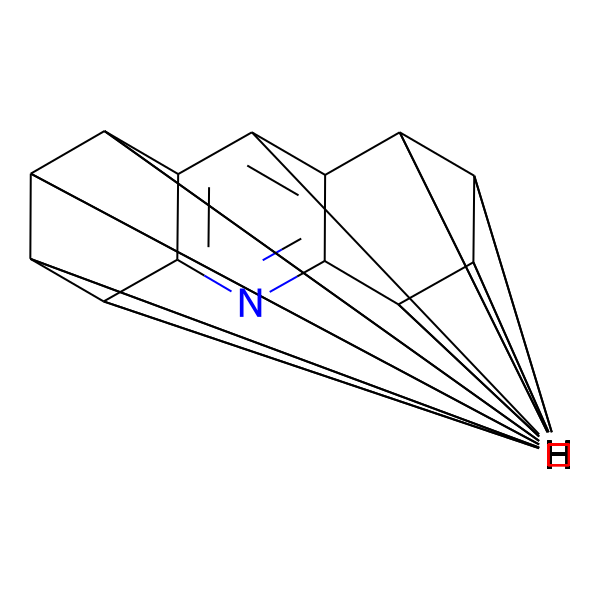

In [70]:
conf_mols[0]

In [ ]:
with StringIO() as f:
    with SDWriter(f) as w:
        for m in mols:
            if mols is None:
                continue
            assert isinstance(m, PropertyMol), "mol is not a PropertyMol"
            w.write(m)
    cont = f.getvalue()

cont = "$$$$".join([c for c in cont.split("$$$$") if len(c) > 3])

with open("test.sdf", "w+",encoding="utf16") as f:
    f.write(cont)

In [68]:
for m in mols:
    #m=m.GetMol()
    m.ClearConformers()
    display(m)
    break

AttributeError: 'PropertyMol' object has no attribute 'ClearConformers'

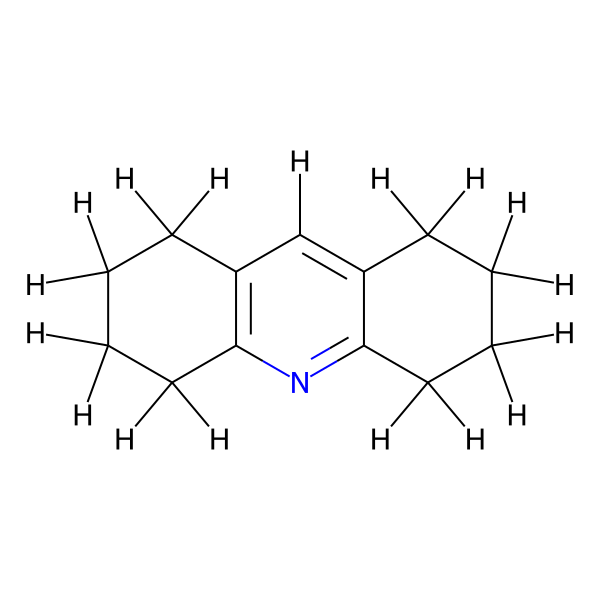

In [93]:
from rdkit.Chem.Draw import IPythonConsole
#Chem.rdDepictor.Compute2DCoords(mols[0])
mols[0].RemoveAllConformers()
mols[0]

In [24]:
mols

In [89]:
Chem.rdchem.RemoveAllConformers()

AttributeError: module 'rdkit.Chem.rdchem' has no attribute 'RemoveConformer'

In [1]:
import requests
response = requests.get(
    "https://sourceforge.net/projects/nmrshiftdb2/files/data/nmrshiftdb2.sd/download",
    timeout=10
    )

In [12]:
str(response.content)[:1000]

"b'warburganal Data in this file is licensed under the nmrshiftdb2 Data License, a copy of which can be found at http://nmrshiftdb.nmr.uni-koeln.de/nmrshiftdbhtml#nmrshiftdb2datalicense.txt\\n  CDKD\\nnmrshiftdb2 234\\n 18 19  0  0  0  0  0  0  0  0999 V2000\\n   -6.4010    0.5490    0.0000 C   0  0  0  0  0  2  0  0  0  0  0  0\\n   -6.4010   -0.9510    0.0000 C   0  0  0  0  0  2  0  0  0  0  0  0\\n   -5.1019   -1.7010    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\\n   -3.8029   -0.9510    0.0000 C   0  0  0  0  0  3  0  0  0  0  0  0\\n   -3.8029    0.5490    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\\n   -5.1019    1.2990    0.0000 C   0  0  0  0  0  2  0  0  0  0  0  0\\n   -2.5039   -1.7010    0.0000 C   0  0  0  0  0  2  0  0  0  0  0  0\\n   -1.2048   -0.9510    0.0000 C   0  0  0  0  0  3  0  0  0  0  0  0\\n   -1.2048    0.5490    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\\n   -2.5039    1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\\n   -3.8029    2.049

In [18]:
with open(FILE, "rb") as f:
    print(sum([1 for _  in sdfclasd(f,sanitize=False)]))
   # for mol in sdfclasd(f):
   #     if mol is None:
   #         continue

44412


In [19]:
import pandas as pd

In [26]:
pd.DataFrame(mols,columns=["mol"])

,mol
0,<rdkit.Chem.PropertyMol.PropertyMol object at ...
1,<rdkit.Chem.PropertyMol.PropertyMol object at ...
2,<rdkit.Chem.PropertyMol.PropertyMol object at ...
3,<rdkit.Chem.PropertyMol.PropertyMol object at ...
4,<rdkit.Chem.PropertyMol.PropertyMol object at ...
5,<rdkit.Chem.PropertyMol.PropertyMol object at ...
6,<rdkit.Chem.PropertyMol.PropertyMol object at ...
7,<rdkit.Chem.PropertyMol.PropertyMol object at ...
8,<rdkit.Chem.PropertyMol.PropertyMol object at ...
9,<rdkit.Chem.PropertyMol.PropertyMol object at ...
